In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Preprocess the data
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = to_categorical(y_train), to_categorical(y_test)


170498071/170498071 [==============================] - 4s 0us/step


In [3]:
from sklearn.model_selection import train_test_split

# Split the data into training (75%), validation (15%), and testing (10%) sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, random_state=42)


In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

# Create a ResNet-50 model with pre-trained weights (include_top=False for feature extraction)
input_tensor = Input(shape=(32, 32, 3))
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Customize the architecture for CIFAR-10
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
output = tf.keras.layers.Dense(10, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output)


94765736/94765736 [==============================] - 0s 0us/step


In [6]:
# Define a custom batch size for faster training
custom_batch_size = 64

# Compile the model with the custom batch size
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with the custom batch size
history = model.fit(x_train, y_train, batch_size=custom_batch_size, validation_data=(x_val, y_val), epochs=5)


Epoch 1/5
665/665 [==============================] - 66s 55ms/step - loss: 1.1541 - accuracy: 0.6203 - val_loss: 2.9634 - val_accuracy: 0.2433
Epoch 2/5
665/665 [==============================] - 34s 51ms/step - loss: 0.7759 - accuracy: 0.7451 - val_loss: 2.0444 - val_accuracy: 0.4380
Epoch 3/5
665/665 [==============================] - 33s 49ms/step - loss: 0.7417 - accuracy: 0.7545 - val_loss: 0.9315 - val_accuracy: 0.7023
Epoch 4/5
665/665 [==============================] - 33s 49ms/step - loss: 0.7597 - accuracy: 0.7464 - val_loss: 1.1944 - val_accuracy: 0.6244
Epoch 5/5
665/665 [==============================] - 34s 52ms/step - loss: 0.5908 - accuracy: 0.8013 - val_loss: 0.8849 - val_accuracy: 0.7156


In [7]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_accuracy}')


313/313 [==============================] - 4s 12ms/step - loss: 0.8949 - accuracy: 0.7165
Test accuracy: 0.7164999842643738


In [8]:
from tensorflow.keras.optimizers import Adam

# Define a custom learning rate and compile the model
custom_lr = 0.001
custom_optimizer = Adam(learning_rate=custom_lr)
model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with 5 epochs
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5)


Epoch 1/5
1329/1329 [==============================] - 92s 46ms/step - loss: 0.8191 - accuracy: 0.7363 - val_loss: 0.8996 - val_accuracy: 0.7036
Epoch 2/5
1329/1329 [==============================] - 60s 45ms/step - loss: 0.6515 - accuracy: 0.7872 - val_loss: 1.0395 - val_accuracy: 0.6620
Epoch 3/5
1329/1329 [==============================] - 62s 47ms/step - loss: 0.5738 - accuracy: 0.8146 - val_loss: 1.0324 - val_accuracy: 0.6787
Epoch 4/5
1329/1329 [==============================] - 60s 45ms/step - loss: 0.5213 - accuracy: 0.8285 - val_loss: 1.3236 - val_accuracy: 0.6011
Epoch 5/5
1329/1329 [==============================] - 61s 46ms/step - loss: 0.4306 - accuracy: 0.8589 - val_loss: 1.1541 - val_accuracy: 0.6635


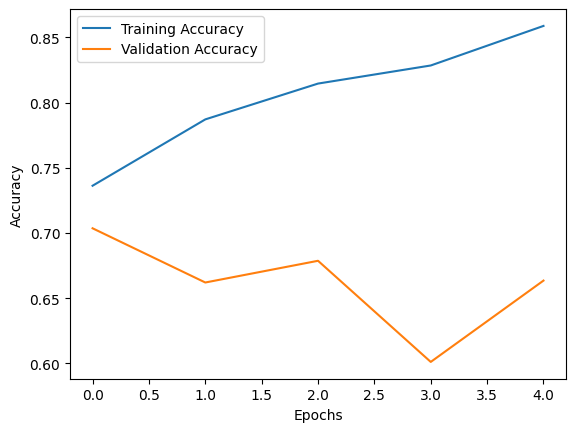

In [11]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


313/313 [==============================] - 10s 20ms/step


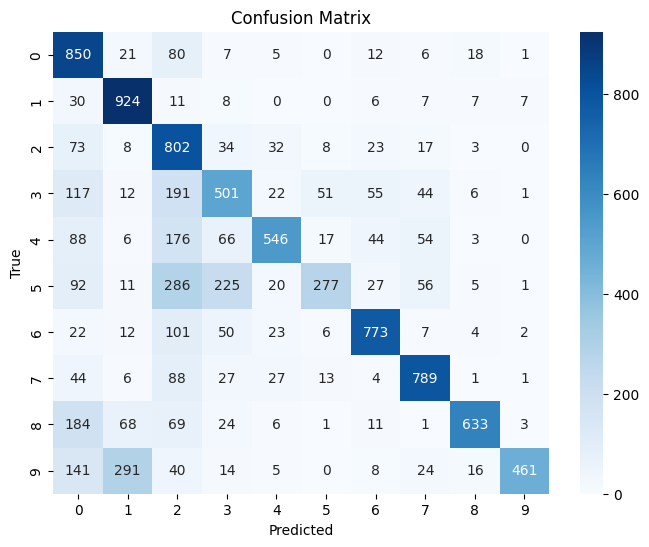

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Obtain predictions on the test set
y_pred = model.predict(x_test)

# Convert one-hot encoded labels back to integers
y_true = [tf.argmax(label).numpy() for label in y_test]
y_pred = [tf.argmax(label).numpy() for label in y_pred]

# Create a confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


313/313 [==============================] - 3s 9ms/step


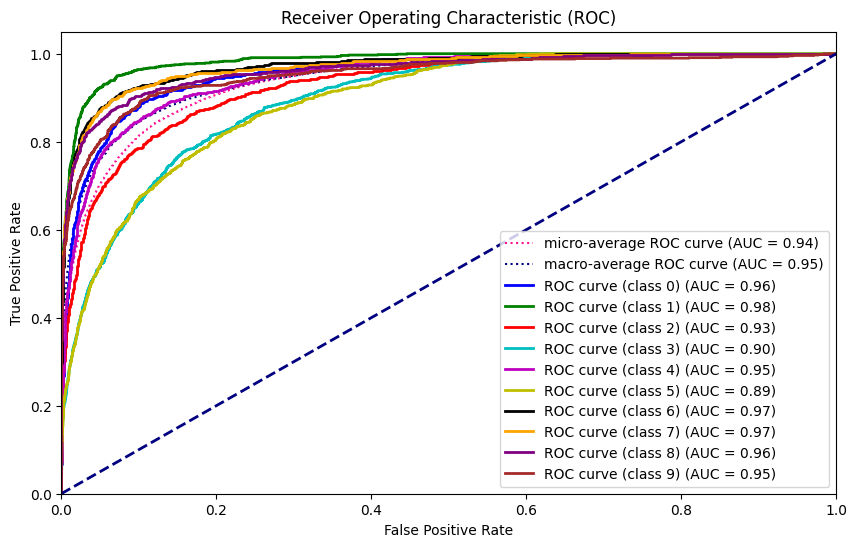

In [13]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import numpy as np

# Binarize the labels for ROC calculation
y_test_binarized = label_binarize(y_test, classes=range(10))

# Calculate ROC curves and AUC for each class
y_pred = model.predict(x_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average ROC curve and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(10)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(10):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= 10
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves for each class, micro-average, and macro-average
plt.figure(figsize=(10, 6))
plt.plot(fpr["micro"], tpr["micro"], label=f'micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})', color='deeppink', linestyle=':')
plt.plot(fpr["macro"], tpr["macro"], label=f'macro-average ROC curve (AUC = {roc_auc["macro"]:.2f})', color='navy', linestyle=':')

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']
for i, color in zip(range(10), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
